In [1]:
import json
import random
from tqdm import tqdm
import numpy as np

from matplotlib import pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

import torch

from pylab import rcParams
rcParams['figure.figsize'] = 15, 15

# Что делать?
Где есть пометка # CODE писать код

[Полезный туториал](http://jalammar.github.io/illustrated-word2vec/)

# Загружаем данные
Они уже обработанные и токенизированные. Процесс можно посмотреть в тетрадке 1.1 Processing corpus

In [2]:
with open('data/processed_corpus.json') as f:
    corpus = json.load(f)

In [3]:
len(corpus)

100000

In [4]:
for text in corpus[:5]:
    print(' '.join(text))

бросать посреди ночь еда отделение перекладывать деньга вручную банкомат
начало год подавать заявка оформление карта одобрить передумать брать карта
почему научить банкомат сообщать маленький история кредитка получать
возврат деньга отказать причина отсутствие чек сказать сотрудник
такой потребовать вышестоящий сотрудник неохота попросить подождать


# CBOW

In [5]:
sample_text = corpus[1]

In [6]:
' '.join(sample_text)

'начало год подавать заявка оформление карта одобрить передумать брать карта'

# Реализуйте разделение предложения на примеры методом CBOW

In [7]:
def cbow_split(tokens, window, pad_token='PAD'):
    
    splits = []
    
    # CODE
    
    tokens = ['PAD'] * window + tokens + ['PAD'] * window
    for i in range(window, len(tokens) - window):
        left_context = tokens[i-window:i]
        central_word = tokens[i]
        right_context = tokens[i+1:i+window+1]
        splits.append((left_context, central_word, right_context))
        
    return splits

In [8]:
splits = cbow_split(sample_text, window=2)

In [9]:
for sample in splits:
    print('Левый контекст:', sample[0])
    print('Центральное слово:', sample[1])
    print('Правый контекст:', sample[2], end='\n\n')

Левый контекст: ['PAD', 'PAD']
Центральное слово: начало
Правый контекст: ['год', 'подавать']

Левый контекст: ['PAD', 'начало']
Центральное слово: год
Правый контекст: ['подавать', 'заявка']

Левый контекст: ['начало', 'год']
Центральное слово: подавать
Правый контекст: ['заявка', 'оформление']

Левый контекст: ['год', 'подавать']
Центральное слово: заявка
Правый контекст: ['оформление', 'карта']

Левый контекст: ['подавать', 'заявка']
Центральное слово: оформление
Правый контекст: ['карта', 'одобрить']

Левый контекст: ['заявка', 'оформление']
Центральное слово: карта
Правый контекст: ['одобрить', 'передумать']

Левый контекст: ['оформление', 'карта']
Центральное слово: одобрить
Правый контекст: ['передумать', 'брать']

Левый контекст: ['карта', 'одобрить']
Центральное слово: передумать
Правый контекст: ['брать', 'карта']

Левый контекст: ['одобрить', 'передумать']
Центральное слово: брать
Правый контекст: ['карта', 'PAD']

Левый контекст: ['передумать', 'брать']
Центральное слово: к

In [10]:
splits

[(['PAD', 'PAD'], 'начало', ['год', 'подавать']),
 (['PAD', 'начало'], 'год', ['подавать', 'заявка']),
 (['начало', 'год'], 'подавать', ['заявка', 'оформление']),
 (['год', 'подавать'], 'заявка', ['оформление', 'карта']),
 (['подавать', 'заявка'], 'оформление', ['карта', 'одобрить']),
 (['заявка', 'оформление'], 'карта', ['одобрить', 'передумать']),
 (['оформление', 'карта'], 'одобрить', ['передумать', 'брать']),
 (['карта', 'одобрить'], 'передумать', ['брать', 'карта']),
 (['одобрить', 'передумать'], 'брать', ['карта', 'PAD']),
 (['передумать', 'брать'], 'карта', ['PAD', 'PAD'])]

# Expected

```python
[(['PAD', 'PAD'], 'вопрос', ['почему', 'например']),
 (['PAD', 'вопрос'], 'почему', ['например', 'китайский']),
 (['вопрос', 'почему'], 'например', ['китайский', 'японский']),
 (['почему', 'например'], 'китайский', ['японский', 'UNK']),
 (['например', 'китайский'], 'японский', ['UNK', 'PAD']),
 (['китайский', 'японский'], 'UNK', ['PAD', 'PAD'])]
```

In [11]:
cbow_split(sample_text, window=3)

[(['PAD', 'PAD', 'PAD'], 'начало', ['год', 'подавать', 'заявка']),
 (['PAD', 'PAD', 'начало'], 'год', ['подавать', 'заявка', 'оформление']),
 (['PAD', 'начало', 'год'], 'подавать', ['заявка', 'оформление', 'карта']),
 (['начало', 'год', 'подавать'],
  'заявка',
  ['оформление', 'карта', 'одобрить']),
 (['год', 'подавать', 'заявка'],
  'оформление',
  ['карта', 'одобрить', 'передумать']),
 (['подавать', 'заявка', 'оформление'],
  'карта',
  ['одобрить', 'передумать', 'брать']),
 (['заявка', 'оформление', 'карта'],
  'одобрить',
  ['передумать', 'брать', 'карта']),
 (['оформление', 'карта', 'одобрить'],
  'передумать',
  ['брать', 'карта', 'PAD']),
 (['карта', 'одобрить', 'передумать'], 'брать', ['карта', 'PAD', 'PAD']),
 (['одобрить', 'передумать', 'брать'], 'карта', ['PAD', 'PAD', 'PAD'])]

# Expected

```python
[(['PAD', 'PAD', 'PAD'], 'вопрос', ['почему', 'например', 'китайский']),
 (['PAD', 'PAD', 'вопрос'], 'почему', ['например', 'китайский', 'японский']),
 (['PAD', 'вопрос', 'почему'], 'например', ['китайский', 'японский', 'UNK']),
 (['вопрос', 'почему', 'например'], 'китайский', ['японский', 'UNK', 'PAD']),
 (['почему', 'например', 'китайский'], 'японский', ['UNK', 'PAD', 'PAD']),
 (['например', 'китайский', 'японский'], 'UNK', ['PAD', 'PAD', 'PAD'])]
```

# Skipgram

In [12]:
' '.join(sample_text)

'начало год подавать заявка оформление карта одобрить передумать брать карта'

# Реализуйте разделение предложения на примеры методом Skipgram

In [13]:
def skipgram_split(tokens, window):
    
    splits = []
    
    # CODE
    
    for i in range(0, len(tokens)):
        for j in range(i-window,i+window+1): 
            if i != j and j >= 0 and j < len(tokens): 
                splits.append((tokens[j], tokens[i])) 
    
    return splits

In [14]:
splits = skipgram_split(sample_text, window=2)

In [15]:
for sample in splits:
    print('Контекст:', sample[0])
    print('Центральное слово:', sample[1], end='\n\n')

Контекст: год
Центральное слово: начало

Контекст: подавать
Центральное слово: начало

Контекст: начало
Центральное слово: год

Контекст: подавать
Центральное слово: год

Контекст: заявка
Центральное слово: год

Контекст: начало
Центральное слово: подавать

Контекст: год
Центральное слово: подавать

Контекст: заявка
Центральное слово: подавать

Контекст: оформление
Центральное слово: подавать

Контекст: год
Центральное слово: заявка

Контекст: подавать
Центральное слово: заявка

Контекст: оформление
Центральное слово: заявка

Контекст: карта
Центральное слово: заявка

Контекст: подавать
Центральное слово: оформление

Контекст: заявка
Центральное слово: оформление

Контекст: карта
Центральное слово: оформление

Контекст: одобрить
Центральное слово: оформление

Контекст: заявка
Центральное слово: карта

Контекст: оформление
Центральное слово: карта

Контекст: одобрить
Центральное слово: карта

Контекст: передумать
Центральное слово: карта

Контекст: оформление
Центральное слово: одобрить

In [16]:
skipgram_split(sample_text, window=2)

[('год', 'начало'),
 ('подавать', 'начало'),
 ('начало', 'год'),
 ('подавать', 'год'),
 ('заявка', 'год'),
 ('начало', 'подавать'),
 ('год', 'подавать'),
 ('заявка', 'подавать'),
 ('оформление', 'подавать'),
 ('год', 'заявка'),
 ('подавать', 'заявка'),
 ('оформление', 'заявка'),
 ('карта', 'заявка'),
 ('подавать', 'оформление'),
 ('заявка', 'оформление'),
 ('карта', 'оформление'),
 ('одобрить', 'оформление'),
 ('заявка', 'карта'),
 ('оформление', 'карта'),
 ('одобрить', 'карта'),
 ('передумать', 'карта'),
 ('оформление', 'одобрить'),
 ('карта', 'одобрить'),
 ('передумать', 'одобрить'),
 ('брать', 'одобрить'),
 ('карта', 'передумать'),
 ('одобрить', 'передумать'),
 ('брать', 'передумать'),
 ('карта', 'передумать'),
 ('одобрить', 'брать'),
 ('передумать', 'брать'),
 ('карта', 'брать'),
 ('передумать', 'карта'),
 ('брать', 'карта')]

# Expected

```python
[('почему', 'вопрос'),
 ('например', 'вопрос'),
 ('вопрос', 'почему'),
 ('например', 'почему'),
 ('китайский', 'почему'),
 ('вопрос', 'например'),
 ('почему', 'например'),
 ('китайский', 'например'),
 ('японский', 'например'),
 ('почему', 'китайский'),
 ('например', 'китайский'),
 ('японский', 'китайский'),
 ('UNK', 'китайский'),
 ('например', 'японский'),
 ('китайский', 'японский'),
 ('UNK', 'японский'),
 ('китайский', 'UNK'),
 ('японский', 'UNK')]
```

In [17]:
skipgram_split(sample_text, window=3)

[('год', 'начало'),
 ('подавать', 'начало'),
 ('заявка', 'начало'),
 ('начало', 'год'),
 ('подавать', 'год'),
 ('заявка', 'год'),
 ('оформление', 'год'),
 ('начало', 'подавать'),
 ('год', 'подавать'),
 ('заявка', 'подавать'),
 ('оформление', 'подавать'),
 ('карта', 'подавать'),
 ('начало', 'заявка'),
 ('год', 'заявка'),
 ('подавать', 'заявка'),
 ('оформление', 'заявка'),
 ('карта', 'заявка'),
 ('одобрить', 'заявка'),
 ('год', 'оформление'),
 ('подавать', 'оформление'),
 ('заявка', 'оформление'),
 ('карта', 'оформление'),
 ('одобрить', 'оформление'),
 ('передумать', 'оформление'),
 ('подавать', 'карта'),
 ('заявка', 'карта'),
 ('оформление', 'карта'),
 ('одобрить', 'карта'),
 ('передумать', 'карта'),
 ('брать', 'карта'),
 ('заявка', 'одобрить'),
 ('оформление', 'одобрить'),
 ('карта', 'одобрить'),
 ('передумать', 'одобрить'),
 ('брать', 'одобрить'),
 ('карта', 'одобрить'),
 ('оформление', 'передумать'),
 ('карта', 'передумать'),
 ('одобрить', 'передумать'),
 ('брать', 'передумать'),
 ('

# Expected

```python
[('почему', 'вопрос'),
 ('например', 'вопрос'),
 ('китайский', 'вопрос'),
 ('вопрос', 'почему'),
 ('например', 'почему'),
 ('китайский', 'почему'),
 ('японский', 'почему'),
 ('вопрос', 'например'),
 ('почему', 'например'),
 ('китайский', 'например'),
 ('японский', 'например'),
 ('UNK', 'например'),
 ('вопрос', 'китайский'),
 ('почему', 'китайский'),
 ('например', 'китайский'),
 ('японский', 'китайский'),
 ('UNK', 'китайский'),
 ('почему', 'японский'),
 ('например', 'японский'),
 ('китайский', 'японский'),
 ('UNK', 'японский'),
 ('например', 'UNK'),
 ('китайский', 'UNK'),
 ('японский', 'UNK')]
```

In [18]:
word2index = {}

for text in corpus:
    for token in text:
        if token not in word2index:
            word2index[token] = len(word2index)

In [19]:
len(word2index)

13120

In [20]:
word2index['UNK']

136

In [21]:
[word2index[tok] if tok in word2index else word2index['UNK'] for tok in 'мама мыть рама'.split()]

[1577, 2640, 136]

# Torch Dataset
В торче есть очень удобная читалка данных

In [22]:
from torch.utils.data import Dataset, DataLoader

In [23]:
# игрушечный датасет
# 121535 примера, 4 фичи, 3 класса
some_data_x = np.random.rand(121535, 4)
some_data_y = np.random.randint(3, size=(121535,))

In [24]:
# соверешенно игрушечный, просто цифры
some_data_x[:10]

array([[0.28878459, 0.38039216, 0.11224513, 0.58694981],
       [0.53072618, 0.04768558, 0.01815138, 0.53512033],
       [0.59584523, 0.36503368, 0.19437463, 0.49533443],
       [0.90068767, 0.90133628, 0.52385459, 0.94501049],
       [0.00778606, 0.82973504, 0.95070977, 0.86591483],
       [0.45647649, 0.7063334 , 0.05579499, 0.46476666],
       [0.87670623, 0.94242956, 0.78980909, 0.27757266],
       [0.87377917, 0.36385703, 0.62191571, 0.39948444],
       [0.44249327, 0.42583712, 0.35883309, 0.09424435],
       [0.05475669, 0.88698137, 0.11495609, 0.12263587]])

In [25]:
some_data_y

array([0, 1, 2, ..., 1, 0, 0])

In [26]:
class ToyDataset(Dataset):
    
    def __init__(self, data_x, data_y):
        
        super().__init__()
        
        self.data_x = data_x
        self.data_y = data_y
        
    def __len__(self):
        
        # Нужно обязательно определить эту функцию
        # Должна возвращать размер датасета
        
        return len(self.data_x)
    
    def __getitem__(self, idx):
        
        # Еще нужно определить этот метод
        # То есть как мы будем доставать наши данные по индексу
        
        return self.data_x[idx], self.data_y[idx]

In [27]:
some_dataset = ToyDataset(some_data_x, some_data_y)

In [28]:
some_dataset[5], some_dataset[467]

((array([0.45647649, 0.7063334 , 0.05579499, 0.46476666]), 1),
 (array([0.39969883, 0.77214412, 0.12860213, 0.15964675]), 1))

In [29]:
some_loader = DataLoader(some_dataset, batch_size=16, shuffle=True)

In [30]:
for x, y in some_loader:
    break
    
len(x), x

(16, tensor([[0.6761, 0.6545, 0.9734, 0.7132],
         [0.0649, 0.9941, 0.8141, 0.7739],
         [0.7591, 0.0892, 0.9868, 0.5314],
         [0.7437, 0.8611, 0.3147, 0.0258],
         [0.4821, 0.6651, 0.7103, 0.3544],
         [0.7257, 0.7556, 0.8889, 0.3145],
         [0.1772, 0.0999, 0.9734, 0.9076],
         [0.6849, 0.7898, 0.5860, 0.4216],
         [0.8813, 0.2124, 0.1331, 0.8812],
         [0.2476, 0.4281, 0.3823, 0.6870],
         [0.7461, 0.4896, 0.9822, 0.9168],
         [0.0217, 0.4750, 0.4509, 0.4114],
         [0.6082, 0.0261, 0.6752, 0.0463],
         [0.1143, 0.3201, 0.1070, 0.5157],
         [0.9709, 0.7156, 0.0254, 0.6180],
         [0.9138, 0.4146, 0.7012, 0.8099]], dtype=torch.float64))

In [31]:
for x, y in some_loader:
    pass

len(x)

15

In [32]:
# почему 13?
# потому что количество наших данных нацело не делится на 16
# и поэтому последний батч меньше 16-ти
len(some_dataset) % 16

15

# А зачем?

In [33]:
class ToyDataset(Dataset):
    
    def __init__(self, data_x, data_y):
        
        super().__init__()
        
        self.data_x = data_x
        self.data_y = data_y
        
    def __len__(self):
        
        # Нужно обязательно определить эту функцию
        # Должна возвращать размер датасета
        
        return len(self.data_x)
    
    @staticmethod
    def add_pow_features(x, n=2):
        
        return np.concatenate([x, x ** n]) 
    
    @staticmethod
    def add_log_features(x):
        
        return np.concatenate([x, np.log(x)]) 
    
    def __getitem__(self, idx):
        
        # Еще нужно определить этот метод
        # То есть как мы будем доставать наши данные по индексу
        
        x = self.data_x[idx]
        
        # внутри датасета мы можем делать все что угодно с нашими данными
        # например выше определим функции, которые добавляют степенные фичи
        x = self.add_pow_features(x, n=2)
        x = self.add_pow_features(x, n=3)
        # и еще возьмем логарифмические фичи
        x = self.add_log_features(x)
        
        y = self.data_y[idx]
        
        return x, y

In [34]:
toy_dataset = ToyDataset(some_data_x, some_data_y)

In [35]:
toy_loader = DataLoader(dataset=toy_dataset, batch_size=128)

In [36]:
for x, y in toy_loader:
    break

In [37]:
x.shape

torch.Size([128, 32])

In [38]:
# заметим, что мы сразу получаем торчовый формат данных
x

tensor([[ 2.8878e-01,  3.8039e-01,  1.1225e-01,  ..., -5.7993e+00,
         -1.3122e+01, -3.1969e+00],
        [ 5.3073e-01,  4.7686e-02,  1.8151e-02,  ..., -1.8259e+01,
         -2.4054e+01, -3.7516e+00],
        [ 5.9585e-01,  3.6503e-01,  1.9437e-01,  ..., -6.0466e+00,
         -9.8278e+00, -4.2151e+00],
        ...,
        [ 6.1900e-01,  6.0609e-01,  8.4095e-01,  ..., -3.0043e+00,
         -1.0394e+00, -1.4368e+01],
        [ 1.8725e-01,  5.1902e-01,  8.3604e-01,  ..., -3.9349e+00,
         -1.0745e+00, -1.6954e+00],
        [ 2.2924e-02,  1.2203e-01,  9.8617e-01,  ..., -1.2621e+01,
         -8.3578e-02, -1.4091e+01]], dtype=torch.float64)

In [39]:
y

tensor([0, 1, 2, 1, 0, 1, 1, 0, 1, 2, 2, 1, 2, 1, 1, 0, 0, 1, 0, 1, 1, 2, 2, 1,
        2, 0, 1, 0, 1, 0, 2, 0, 1, 2, 1, 0, 1, 0, 2, 2, 1, 2, 1, 0, 2, 1, 0, 2,
        0, 2, 0, 0, 2, 1, 2, 1, 2, 2, 2, 1, 2, 1, 0, 2, 1, 2, 1, 0, 0, 1, 2, 1,
        0, 2, 0, 0, 1, 2, 2, 0, 2, 0, 2, 2, 0, 0, 2, 1, 2, 2, 2, 2, 1, 0, 2, 2,
        0, 1, 1, 0, 0, 1, 1, 2, 1, 2, 1, 1, 2, 0, 0, 1, 2, 0, 0, 2, 1, 0, 2, 2,
        1, 2, 2, 0, 2, 2, 2, 2])

# Если вы ничего здесь не понимаете, то вернитесь в конец первой домашки, там все объясняется

In [40]:
model = torch.nn.Sequential(torch.nn.Linear(32, 16),
                            torch.nn.ReLU(),
                            torch.nn.Linear(16, 8),
                            torch.nn.ReLU(),
                            torch.nn.Linear(8, 3))

criterion = torch.nn.CrossEntropyLoss()

In [41]:
with torch.no_grad():

    prediction = model(x.float())

    loss = criterion(prediction, y)
    
loss.item()

1.133729100227356

# Боевые датасеты

In [42]:
class CBOWDataset(Dataset):

    def __init__(self,
                 corpus,
                 word2index,
                 window=2,
                 unk_token='UNK',
                 pad_token='PAD',
                 collect_verbose=True):

        self.corpus = corpus
        self.word2index = word2index
        self.index2word = {value: key for key, value in self.word2index.items()}
        self.window = window

        self.unk_token = unk_token
        self.unk_index = self.word2index[self.unk_token]

        self.pad_token = pad_token
        self.pad_index = len(self.word2index)

        self.collect_verbose = collect_verbose

        self.data = []

        self.collect_data()

    def __len__(self):

        return len(self.data)

    def _split_function(self, tokenized_text):

        splits = []

        for n in range(len(tokenized_text)):
            left_context = tokenized_text[np.maximum(n - self.window, 0):n]
            left_context = ([self.pad_index] * (self.window - len(left_context))) + left_context

            central_word = tokenized_text[n]

            right_context = tokenized_text[n + 1:n + self.window + 1]
            right_context = right_context + ([self.pad_index] * (self.window - len(right_context)))

            splits.append((left_context + right_context, central_word))

        return splits

    def indexing(self, tokenized_text):

        return [self.word2index[token] if token in self.word2index else self.unk_index for token in tokenized_text]

    def collect_data(self):

        corpus = tqdm(self.corpus, disable=not self.collect_verbose)

        for tokenized_text in corpus:
            indexed_text = self.indexing(tokenized_text)
            cbow_examples = self._split_function(indexed_text)

            self.data.extend(cbow_examples)

    def __getitem__(self, idx):

        context, central_word = self.data[idx]

        context = torch.Tensor(context).long()

        return context, central_word

# Мы будем учить модель Skipgram
Реализуйте читалку данных

In [43]:
class SkipgramDataset(Dataset):

    def __init__(self,
                 corpus,
                 word2index,
                 window=2,
                 unk_token='UNK',
                 collect_verbose=True):

        self.corpus = corpus
        self.word2index = word2index
        self.index2word = {value: key for key, value in self.word2index.items()}
        self.window = window

        self.unk_token = unk_token
        self.unk_index = self.word2index[self.unk_token]

        self.collect_verbose = collect_verbose

        self.data = []

        self.collect_data()

    def __len__(self):

        return len(self.data)

    def _split_function(self, tokenized_text):
        
        # CODE
        
        # вставить здесь функцию, которые вы писали раньше

        splits = []
        
        for i in range(len(tokenized_text)):
            for j in range(i-self.window,i+self.window+1): 
                if i != j and j >= 0 and j < len(tokenized_text): 
                    splits.append((tokenized_text[j], tokenized_text[i])) 

        return splits

    def indexing(self, tokenized_text):

        return [self.word2index[token] if token in self.word2index else self.unk_index for token in tokenized_text]

    def collect_data(self):

        corpus = tqdm(self.corpus, disable=not self.collect_verbose)

        for tokenized_text in corpus:
            indexed_text = self.indexing(tokenized_text)
            skipgram_examples = self._split_function(indexed_text)

            self.data.extend(skipgram_examples)

    def __getitem__(self, idx):
        
        # CODE
        
        context, central_word = self.data[idx]

        #context = torch.Tensor(context).long()

        return central_word, context

In [44]:
#from word2vec_utils import SkipgramDataset

In [45]:
dataset = SkipgramDataset(corpus, word2index)

100%|██████████| 100000/100000 [00:01<00:00, 70996.62it/s]


In [46]:
BATCH_SIZE = 512

In [47]:
dataset_loader = DataLoader(dataset, shuffle=True, batch_size=BATCH_SIZE)

In [48]:
for x, y in dataset_loader:
    break

In [49]:
x[:5]

tensor([ 644,  293,  279, 4848,   31])

In [50]:
y[:5]

tensor([2077,  591,  112, 5641,  345])

In [51]:
print([dataset.index2word[w] for w in x[:5].numpy()])
print([dataset.index2word[w] for w in y[:5].numpy()])

['реклама', 'обратиться', 'вернуть', 'переговоры', 'сотрудник']
['мошенничество', 'звонок', 'заблокировать', 'смольный', 'заявление']


In [52]:
x.shape, y.shape

(torch.Size([512]), torch.Size([512]))

In [53]:
class CBOW(torch.nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, pad_index):
        
        super().__init__()
        
        if pad_index > 0:
            vocab_size += 1
        
        self.in_embedding = torch.nn.Embedding(num_embeddings=vocab_size, 
                                               embedding_dim=embedding_dim,
                                               padding_idx=pad_index)
        
        self.out_embedding = torch.nn.Linear(in_features=embedding_dim,
                                             out_features=vocab_size, bias=False)
        
    def forward(self, x):
        
        x = self.in_embedding(x).sum(dim=-2)
        x = self.out_embedding(x)
        
        return x

# Мы будем учить модель Skipgram
Реализуйте ее

In [54]:
# CODE

class SkipGram(torch.nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        
        super().__init__()
        
        self.in_embedding = torch.nn.Embedding(num_embeddings=vocab_size, 
                                               embedding_dim=embedding_dim)
        
        self.out_embedding = torch.nn.Linear(in_features=embedding_dim,
                                             out_features=vocab_size, bias=False)
        
#         self.softmax = torch.nn.Softmax(dim=-1)
        
    def forward(self, x):
        
        x = self.in_embedding(x)
        x = self.out_embedding(x)
#         x = self.softmax(x)
        
        return x

In [55]:
#from word2vec_utils import SkipGram

In [56]:
# размерность эмбеддинга
# маленькая, чтобы мы могли недолго поучить ворд2век и увидеть результаты
EMBEDDING_DIM = 20

In [57]:
model = SkipGram(vocab_size=len(word2index), embedding_dim=EMBEDDING_DIM)

In [58]:
model.cuda()

SkipGram(
  (in_embedding): Embedding(13120, 20)
  (out_embedding): Linear(in_features=20, out_features=13120, bias=False)
)

In [59]:
with torch.no_grad():
    pred = model(x.cuda())

pred.shape

torch.Size([512, 13120])

In [60]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

# aka loss function
criterion = torch.nn.CrossEntropyLoss()

# Допишите обучалку

In [61]:
epochs = 3

losses = []

for n_epoch in range(epochs):

    try:

        progress_bar = tqdm(total=len(dataset_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))

        for x, y in dataset_loader:

            # CODE
            
            optimizer.zero_grad()

            y_pred = model(x.cuda())
            
            loss = criterion(y_pred, y.cuda())
            loss.backward()
            optimizer.step()
            
            # CODE
            
            losses.append(loss.item())
            
            progress_bar.set_postfix(loss=np.mean(losses[-100:]))

            progress_bar.update(x.shape[0])

        progress_bar.close()

    except KeyboardInterrupt:

        progress_bar.close()
        break

Epoch 3: 100%|██████████| 2983846/2983846 [00:33<00:00, 89426.92it/s, loss=6.89]


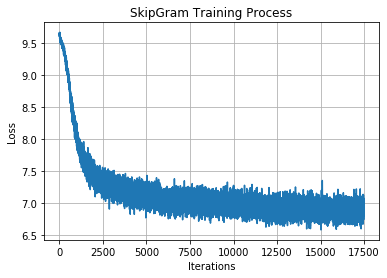

In [62]:
plt.title('SkipGram Training Process')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid()
plt.plot(losses)

In [63]:
# проверка, что хоть что-то выучилось
assert np.mean(losses[-1000:]) < 7.5

In [64]:
embedding_matrix = model.in_embedding.weight.detach()

In [65]:
def cos_sim(embedding_matrix, token2id, word1, word2):
    
    i1 = token2id[word1]
    i2 = token2id[word2]
    
    v1, v2 = embedding_matrix[i1], embedding_matrix[i2]
    
    v1_n = v1.div(v1.norm(keepdim=True))
    v2_n = v2.div(v2.norm(keepdim=True))
    
    similarity = torch.dot(v1_n, v2_n).item()
    
    return similarity

# Косинусная близость
От 0 до 1, где 0 - вектора абсолютно разные, где 1 - идентичные.

In [66]:
cos_sim(embedding_matrix, word2index, 'день', 'месяц')

0.6989378333091736

In [67]:
cos_sim(embedding_matrix, word2index, 'минута', 'месяц')

0.41423436999320984

In [68]:
cos_sim(embedding_matrix, word2index, 'сотрудник', 'сотрудница')

0.5767256021499634

In [69]:
cos_sim(embedding_matrix, word2index, 'вклад', 'перевод')

0.19721204042434692

In [70]:
cos_sim(embedding_matrix, word2index, 'король', 'королева')

-0.15932944416999817

In [71]:
random_word = random.choice(list(word2index.keys()))
sim = cos_sim(embedding_matrix, word2index, 'день', random_word)
'Косинусная близость слова "день" к случайному выбраному слову "{}" равна {:.3f}'.format(random_word, sim)

'Косинусная близость слова "день" к случайному выбраному слову "доходность" равна 0.162'

In [72]:
freq = {}

for text in corpus:
    for token in text:
        if token in freq:
            freq[token] += 1
        else:
            freq[token] = 1

In [73]:
sorted_freq = [(k, freq[k]) for k in sorted(freq, key=freq.get, reverse=True)]
top_sorted_freq = sorted_freq[0:200]

In [74]:
tsne = TSNE(n_components=2, init='pca', random_state=42, verbose=2)
reduced = tsne.fit_transform(embedding_matrix.cpu())

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 13120 samples in 0.012s...
[t-SNE] Computed neighbors for 13120 samples in 5.941s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13120
[t-SNE] Computed conditional probabilities for sample 2000 / 13120
[t-SNE] Computed conditional probabilities for sample 3000 / 13120
[t-SNE] Computed conditional probabilities for sample 4000 / 13120
[t-SNE] Computed conditional probabilities for sample 5000 / 13120
[t-SNE] Computed conditional probabilities for sample 6000 / 13120
[t-SNE] Computed conditional probabilities for sample 7000 / 13120
[t-SNE] Computed conditional probabilities for sample 8000 / 13120
[t-SNE] Computed conditional probabilities for sample 9000 / 13120
[t-SNE] Computed conditional probabilities for sample 10000 / 13120
[t-SNE] Computed conditional probabilities for sample 11000 / 13120
[t-SNE] Computed conditional probabilities for sample 12000 / 13120
[t-SNE] Computed conditional probabilities for sam

In [75]:
top_words = [a for a,_ in top_sorted_freq]

In [76]:
inds = [word2index[word] for word in top_words]
x_coords = [coords[0] for coords in reduced[inds]]
y_coords = [coords[1] for coords in reduced[inds]]

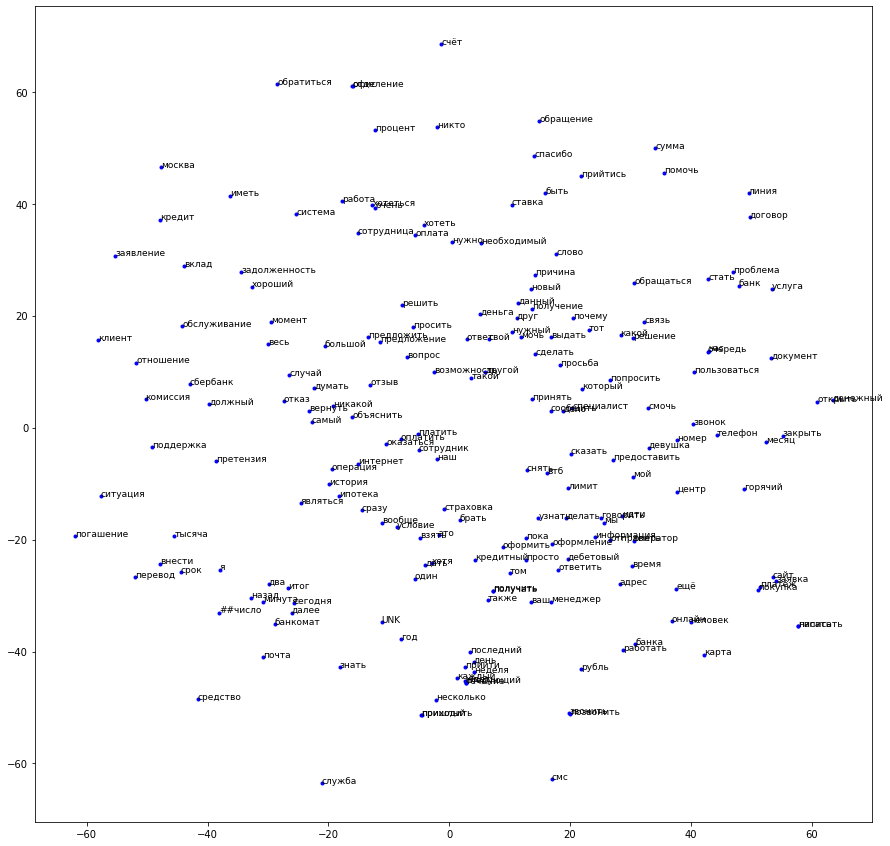

In [85]:
plt.figure(figsize=(15, 15))
for (x, y, word) in zip(x_coords, y_coords, top_words):
    plt.scatter(x, y, marker='.', color='blue')
    plt.text(x+0.01, y+0.01, word, fontsize=9)
plt.show()